# Performance comparison

This notebook compares the performance of `cuDF` and `pandas`. The comparisons performed are on identical data sizes. This notebook primarily showcases the factor
of speedups users can have when the similar `pandas` APIs are run on GPUs using `cudf`.

The hardware details used to run these performance comparisons are at the end of this page.

In [1]:
import os
import time
import timeit
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cudf

In [2]:
np.random.seed(0)

## Concat, count & joins performance

In [3]:
num_rows = 300_000_000
pdf = pd.DataFrame(
    {
        "numbers": np.random.randint(-1000, 1000, num_rows, dtype="int64"),
        "business": np.random.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=num_rows
        ),
    }
)
pdf

,numbers,business
0,-316,Costco
1,-441,Costco
2,653,Buckees
3,216,Buckees
4,-165,Walmart
...,...,...
299999995,-395,Walmart
299999996,-653,Buckees
299999997,364,Buckees
299999998,159,Buckees


In [4]:
gdf = cudf.from_pandas(pdf)
gdf

,numbers,business
0,-316,Costco
1,-441,Costco
2,653,Buckees
3,216,Buckees
4,-165,Walmart
...,...,...
299999995,-395,Walmart
299999996,-653,Buckees
299999997,364,Buckees
299999998,159,Buckees


In [5]:
def timeit_pandas_cudf(pd_obj, gd_obj, func, **kwargs):
    """
    A utility function to measure execution time of an
    API(`func`) in pandas & cudf.

    Parameters
    ----------
    pd_obj : Pandas object
    gd_obj : cuDF object
    func : callable
    """
    pandas_time = timeit.timeit(lambda: func(pd_obj), **kwargs)
    cudf_time = timeit.timeit(lambda: func(gd_obj), **kwargs)
    return pandas_time, cudf_time

In [6]:
pandas_value_counts, cudf_value_counts = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.value_counts(), number=30
)

In [7]:
pdf = pdf.head(100_000_000)
gdf = gdf.head(100_000_000)

In [8]:
pandas_concat = timeit.timeit(lambda: pd.concat([pdf, pdf, pdf]), number=30)

In [9]:
cudf_concat = timeit.timeit(lambda: cudf.concat([gdf, gdf, gdf]), number=30)

In [10]:
pandas_groupby, cudf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby("business").agg(["min", "max", "mean"]),
    number=30,
)

In [11]:
num_rows = 1_000_000
pdf = pd.DataFrame(
    {
        "numbers": np.random.randint(-1000, 1000, num_rows, dtype="int64"),
        "business": np.random.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=num_rows
        ),
    }
)
gdf = cudf.from_pandas(pdf)

In [12]:
pandas_merge, cudf_merge = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.merge(df), number=30
)

In [13]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_value_counts / cudf_value_counts,
            pandas_concat / cudf_concat,
            pandas_groupby / cudf_groupby,
            pandas_merge / cudf_merge,
        ],
    },
    index=["value_counts", "concat", "groupby", "merge"],
)

In [14]:
performance_df

,cudf speedup vs. pandas
value_counts,282.901300
concat,203.624680
groupby,138.495762
merge,136.519031


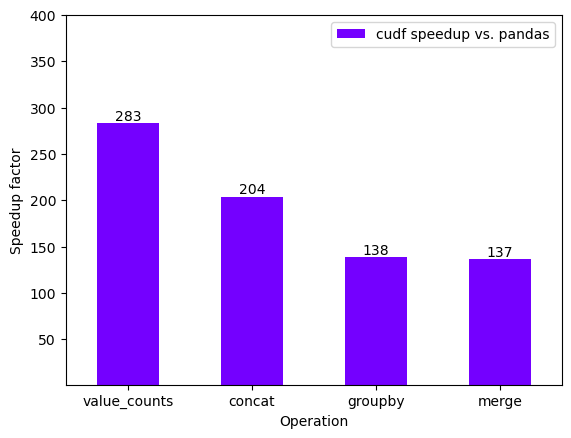

In [15]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 400),
    rot=0,
    xlabel="Operation",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

In [16]:
# Cleaning up used memory for later benchmarks
del pdf
del gdf
import gc

_ = gc.collect()

## Strings Performance

In [17]:
pd_series = pd.Series(
    np.random.choice(
        ["123", "56.234", "Walmart", "Costco", "rapids ai"], size=300_000_000
    )
)

In [18]:
gd_series = cudf.from_pandas(pd_series)

In [19]:
pandas_upper, cudf_upper = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.upper(), number=20
)

In [20]:
pandas_contains, cudf_contains = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.contains(r"[0-9][a-z]"), number=20
)

In [21]:
pandas_isalpha, cudf_isalpha = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.isalpha(), number=20
)

In [22]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_upper / cudf_upper,
            pandas_contains / cudf_contains,
            pandas_isalpha / cudf_isalpha,
        ],
    },
    index=["upper", "contains", "isalpha"],
)

In [23]:
performance_df

,cudf speedup vs. pandas
upper,1832.120875
contains,1311.758332
is_alpha,5752.301339


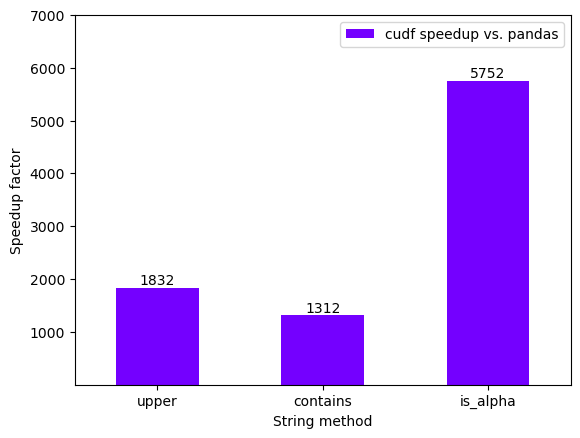

In [24]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 7000),
    rot=0,
    xlabel="String method",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

## User-defined function (UDF) performance (with JIT overhead)

The first UDF runs include JIT compilation overhead, due to which the performance of first run and average of next few runs are compared separately.

In [25]:
num_rows = 10_000_000
pdf_age = pd.DataFrame(
    {
        "age": np.random.randint(0, 100, num_rows),
    }
)
pdf_age

,age
0,87
1,71
2,63
3,40
4,92
...,...
9999995,4
9999996,28
9999997,31
9999998,4


In [26]:
gdf_age = cudf.from_pandas(pdf_age)
gdf_age

,age
0,87
1,71
2,63
3,40
4,92
...,...
9999995,4
9999996,28
9999997,31
9999998,4


In [27]:
def age_udf(row):
    if row["age"] < 18:
        return 0
    elif 18 <= row["age"] < 20:
        return 1
    elif 20 <= row["age"] < 30:
        return 2
    elif 30 <= row["age"] < 40:
        return 3
    elif 40 <= row["age"] < 50:
        return 4
    elif 50 <= row["age"] < 60:
        return 5
    elif 60 <= row["age"] < 70:
        return 6
    else:
        return 7

In [28]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=1
)

In [29]:
def str_isupper_udf(row):
    if row.isupper():
        return 0
    else:
        return 1

In [30]:
pd_series = pd.Series(
    np.random.choice(["ABC", "abc", "hello world", "AI"], size=100_000_000),
    name="strings",
)
pd_series

0                    AI
1                   ABC
2           hello world
3                   abc
4           hello world
               ...     
99999995             AI
99999996             AI
99999997            abc
99999998            abc
99999999    hello world
Name: strings, Length: 100000000, dtype: object

In [31]:
gd_series = cudf.from_pandas(pd_series)
gd_series

0                    AI
1                   ABC
2           hello world
3                   abc
4           hello world
               ...     
99999995             AI
99999996             AI
99999997            abc
99999998            abc
99999999    hello world
Name: strings, Length: 100000000, dtype: object

In [32]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=1
)

In [34]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

,cudf speedup vs. pandas
Numeric,362.091673
String,204.865789


Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their first runs.

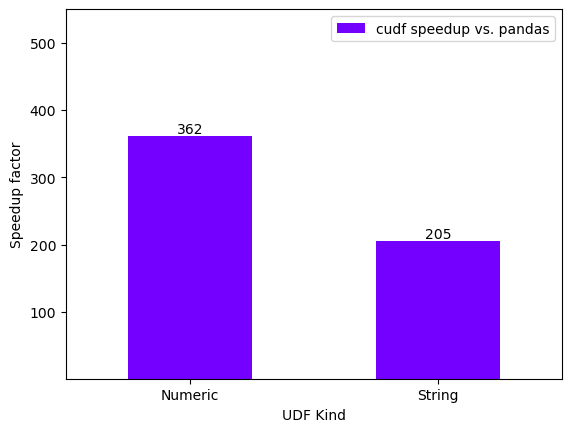

In [35]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 550),
    rot=0,
    xlabel="UDF Kind",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

## User-defined function (UDF) performance (without JIT overhead)

In [36]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=10
)

In [37]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=10
)

In [39]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

,cudf speedup vs. pandas
Numeric,95448.144630
String,2587.570338


Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their consequent runs. In this case the speedup is massive because of no JIT overhead present.

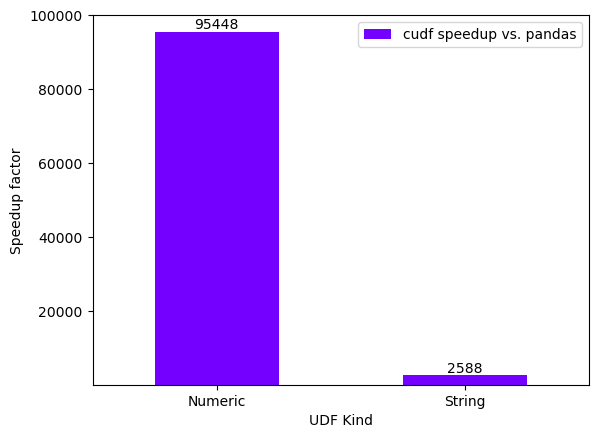

In [40]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 100000),
    rot=0,
    xlabel="UDF Kind",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

## UDF Performance in GroupBy

In [41]:
size = 100_000_000
pdf = pd.DataFrame()
pdf["key"] = np.random.randint(0, 2, size)
pdf["val"] = np.random.randint(0, 7, size)


def custom_formula_udf(df):
    df["out"] = df["key"] * df["val"] - 10
    return df


gdf = cudf.from_pandas(pdf)

In [42]:
pandas_udf_groupby, cudf_udf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby(["key"], group_keys=False).apply(custom_formula_udf),
    number=10,
)

In [44]:
performance_df = pd.DataFrame(
    {"cudf speedup vs. pandas": [pandas_udf_groupby / cudf_udf_groupby]},
    index=["Grouped UDF"],
)
performance_df

,cudf speedup vs. pandas
Grouped UDF,423.83606


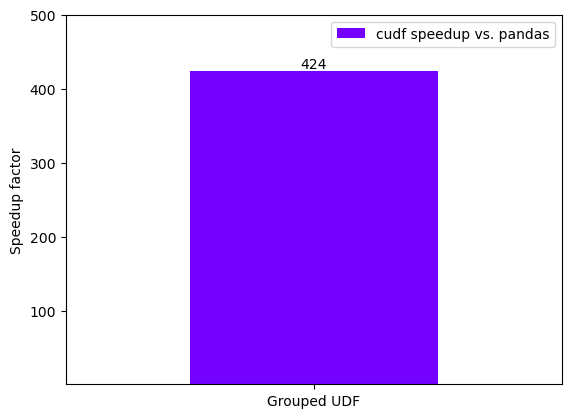

In [45]:
ax = performance_df.plot.bar(
    color="#7400ff", ylim=(1, 500), rot=0, ylabel="Speedup factor"
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

# System Configuration

## CPU Configuration

In [46]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          80
On-line CPU(s) list:             0-79
Thread(s) per core:              2
Core(s) per socket:              20
Socket(s):                       2
NUMA node(s):                    2
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz
Stepping:                        7
CPU MHz:                         800.049
CPU max MHz:                     3900.0000
CPU min MHz:                     800.0000
BogoMIPS:                        4200.00
Virtualization:                  VT-x
L1d cache:                       1.3 MiB
L1i cache:                       1.3 MiB
L2 cache:                        40 MiB
L3 cache:                     

## GPU Configuration

In [47]:
!nvidia-smi

Mon Feb  6 17:43:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.04    Driver Version: 525.60.04    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  H100 80GB HBM2e     On   | 00000000:1E:00.0 Off |                    0 |
| N/A   30C    P0    60W / 700W |      0MiB / 81559MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  H100 80GB HBM2e     On   | 00000000:22:00.0 Off |                    0 |
| N/A   